In [16]:
import os
os.chdir("/home/yangkai/codegen-detection/")

In [3]:
from simcse.simcse import RobertaForCL
from transformers import AutoTokenizer
import torch
from tqdm import tqdm

bsz = 32
device = 5
model_args = {'pooler_type':'cls','temp':0.1,'mlp_only_train':True}
# model = RobertaForCL.from_pretrained("simcse/ckpt_gcb4_codenet_py_no_overlap/best_model",**model_args)
model = RobertaForCL.from_pretrained("simcse/ckpt_gcb/best_model",**model_args)
# model = RobertaForCL.from_pretrained("simcse/ckpt_gcb4_csn_pyjava/best_model",**model_args)


# model_args = {'pooler_type':'avg','temp':0.1,'mlp_only_train':True}
# model = RobertaForCL.from_pretrained("microsoft/graphcodebert-base",**model_args)

tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")
# tokenizer = AutoTokenizer.from_pretrained("microsoft/unixcoder-base")

model = model.to(device)

@torch.inference_mode()
def pipeline(texts):
    inputs = tokenizer(texts,return_tensors='pt',padding=True,add_special_tokens=True,truncation=True)
    inputs = {k:v.to(device) for k,v in inputs.items()}
    sent_embed = model(**inputs,sent_emb=True).pooler_output

    return sent_embed

@torch.inference_mode()
def batch_encode(texts):
    embeds = []
    for i in tqdm(range(0,len(texts),bsz)):
        chunk = texts[i:i+bsz]
        embeds.append(pipeline(chunk))
    
    return torch.cat(embeds,dim=0)

def get_sim(data,resample_keys,orig_key):
    orig_embed = batch_encode(data[orig_key].tolist())
    resample_embeds = []
    for key in resample_keys:
        resample_embeds.append(batch_encode(data[key].tolist()))
    
    all_sim = []
    normed_orig_embed = torch.nn.functional.normalize(orig_embed,p=2,dim=-1)
    for embed in resample_embeds:
        normed_embed = torch.nn.functional.normalize(embed,p=2,dim=-1)
        sim = (normed_orig_embed * normed_embed).sum(-1)
        all_sim.append(sim)
    
    return all_sim

/home/yangkai/anaconda3/envs/torch20-cu117/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/yangkai/anaconda3/envs/torch20-cu117/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /home/yangkai/anaconda3/envs/torch20-cu117/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/yangkai/anaconda3/envs/torch20-cu117/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/home/yangkai/anaconda3/envs/torch20-cu117/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/home/yangkai/anaconda3/envs/torch20-cu117/lib/libcudart.so'), PosixPath('/home/yangkai/anaconda3/envs/torch20-cu117/lib/libcudart.so.11.0')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] in the paths that we search based on your env.
  warn(msg)


[2024-03-25 17:02:00,078] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
{'pooler_type': 'cls', 'temp': 0.1, 'mlp_only_train': True}


In [30]:
# gen_model: gpt35
# rewrite_model: codellama
import json
from response_extraction import step1_extract_code,step2_code_filter
def json_load(fname):
    responses = [json.loads(line.strip()) for line in open(fname).readlines()]
    extracted = []
    for i in range(8):
        codes = []
        for resp in responses:
            try:
                code = step2_code_filter(step1_extract_code(resp['choices'][i]['message']['content']))
            except:
                code = ""
            codes.append(code)
        extracted.append(codes)
    return extracted

def load(fname):
    # print(fname)
    return [json.loads(line.strip()) for line in open(fname).readlines()]
# code_contest_java_gen
dset = "mbpp"
rewrite_model = "gpt35"
gen_model = "_starchat" # ["","_codellama","_starchat","_gpt4"]
hum_pth = f"dataset/{dset}_hum_test.pkl" # 如果是gpt4，就是 dataset/{dset}_hum_test100.pkl
gen_pth = f"dataset/{dset}_gen_test{gen_model}.pkl" # dataset/{dset}_gen_test100{gen_model}.pkl

hum_rewrites = [load(f"prompt_gpt/{dset}_hum_test_{rewrite_model}_rewrite_resp{id}.jsonl") for id in range(1,9)]
gen_rewrites = [load(f"prompt_gpt/{dset}_gen_test{gen_model}_{rewrite_model}_rewrite_resp{id}.jsonl") for id in range(1,9)]
# gen_rewrites = json_load(f"prompt_gpt/{dset}_gen_test{gen_model}_{rewrite_model}_rewrite_resp1.jsonl")

In [31]:
import pandas as pd
import json

def data_prepare(orig_pth,rewrites):
    print(orig_pth)
    df = pd.read_pickle(orig_pth)[['extracted_full_func','problem_id']]
    # df['extracted_full_func'].apply(lambda x:x.strip())
    for i,rewrite in enumerate(rewrites):
        try:
            df[f'rewrite_{i}'] = [item['code'] for item in rewrite]
        except:
            df[f'rewrite_{i}'] = rewrite
    
    return df

hum_df = data_prepare(hum_pth,hum_rewrites)
# hum_df = pd.read_pickle(hum_pth)
gen_df = data_prepare(gen_pth,gen_rewrites)

# gen_df = gen_df[gen_df.pid.isin(hum_df.pid.to_list())]

# correct_ids = pd.read_pickle("dataset/mbpp_gen_test_correct.pkl")['problem_id'].tolist()
# gen_df = gen_df[~gen_df['problem_id'].isin(correct_ids)]
# hum_df = hum_df.sample(n=len(gen_df),random_state=42)

# gen_df = pd.read_pickle("dataset/apps_gen_test.pkl")
# hum_df = pd.read_pickle(hum_pth)
len(hum_df),len(gen_df)


dataset/apps_hum_test.pkl
dataset/apps_gen_test_starchat.pkl


(770, 770)

In [18]:
df = pd.read_pickle("dataset/apps_gen_test_starchat.pkl")
for name in df.columns:
    print(name)

problem_id
question
solutions
difficulty
url
starter_code
apps_split
code_source
solution
extracted_full_func
extracted_full_func_word_prob_CodeLlama-13b-Instruct-hf
extracted_full_func_word_rank_CodeLlama-13b-Instruct-hf
extracted_full_func_entropy_CodeLlama-13b-Instruct-hf
extracted_full_func_word_prob_starchat-alpha
extracted_full_func_word_rank_starchat-alpha
extracted_full_func_entropy_starchat-alpha
extracted_full_func_word_prob_incoder-6B
extracted_full_func_word_rank_incoder-6B
extracted_full_func_entropy_incoder-6B
extracted_full_func_word_prob_codegen-2B-mono
extracted_full_func_word_rank_codegen-2B-mono
extracted_full_func_entropy_codegen-2B-mono
extracted_full_func_word_prob_PolyCoder-160M
extracted_full_func_word_rank_PolyCoder-160M
extracted_full_func_entropy_PolyCoder-160M


In [28]:
# gen_subset = pd.read_pickle("dataset/mbpp_gen_test100.pkl")
# hum_subset = pd.read_pickle("dataset/mbpp_hum_test100.pkl")
# gen_df = gen_df[gen_df.problem_id.isin(gen_subset.problem_id.tolist())]
# hum_df = hum_df[hum_df.problem_id.isin(hum_subset.problem_id.tolist())]
# len(gen_df),len(hum_df)
# def check(x):
#     print(x + "\n==========")
# hum_df['rewrite_0'].apply(check)

In [32]:
# hum_sim = get_sim(hum_df,['vicuna_resampled_code_cleaned','vicuna_resampled_code_cleaned2']+ [f'gpt_resample_code_cleaned{i}' for i in range(3,9)],'extracted_full_func')
# hum_sim = get_sim(hum_df,[f'gpt_resample_code_cleaned{i}' for i in range(1,9)],'extracted_full_func')
gen_sim = get_sim(gen_df,[f'rewrite_{i}' for i in range(8)],'extracted_full_func')
hum_sim = get_sim(hum_df,[f'rewrite_{i}' for i in range(8)],'extracted_full_func')
# gen_sim = get_sim(gen_df,['vicuna_resampled_code_cleaned','vicuna_resampled_code_cleaned2']+ [f'gpt_resample_code_cleaned{i}' for i in range(3,9)],'extracted_full_func')

100%|██████████| 25/25 [00:06<00:00,  3.78it/s]


In [33]:
from sklearn.metrics import roc_auc_score
all_sim = [torch.concat([sim1,sim2]) for sim1,sim2 in zip(gen_sim,hum_sim)]
label = [1] * len(gen_df) + [0] * len(hum_df)

roc_aucs = []
for m in range(1,9):
    score = sum([all_sim[i] for i in range(m)]) / m
    # score = (all_sim[0] + all_sim[1]) / 2

    score = score.tolist()

    roc_auc = roc_auc_score(label,score)
    roc_aucs.append(roc_auc)
    if m in [2,4,8,16,32]:
        print(m,roc_auc)

2 0.7723680215888009
4 0.7944172710406476
8 0.813496373756114


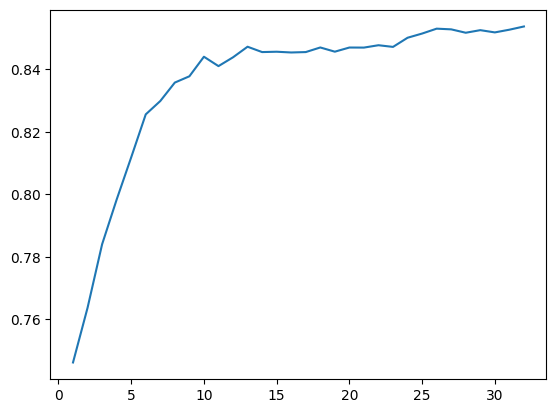

In [22]:
import matplotlib.pyplot as plt
import pickle
plt.plot(list(range(1,33)),roc_aucs)
pickle.dump(roc_aucs,open("roc_aucs_mbpp_codellama_rewrite_m32.pkl","wb"))

In [39]:
import pandas as pd
hum_data = pd.read_pickle("dataset/mbpp_hum_test100.pkl")
gen_data = pd.read_pickle("dataset/mbpp_gen_test100_gpt4.pkl")

In [40]:
def line_cnt(x):
    return len(x.split("\n"))
hum_len = hum_data['extracted_full_func'].apply(line_cnt).sum() / len(hum_data)
gen_len = gen_data['extracted_full_func'].apply(line_cnt).sum() / len(gen_data)
hum_len,gen_len

(10.43, 8.44)

## Other Similarity Metrics

In [18]:
from fuzzywuzzy import fuzz
from collections import Counter
def get_sim_levinshtein(data,resample_keys,orig_key):
    orig_texts = data[orig_key].tolist()
    resample_texts = []
    for key in resample_keys:
        resample_texts.append(data[key].tolist())
    
    all_sim = []
    for texts in resample_texts:
        sim = [fuzz.ratio(a,b) for a,b in zip(orig_texts,texts)]
        all_sim.append(sim)
    
    return torch.tensor(all_sim)


def bow_sim(a,b):
    n_overlap = 0
    for k in b:
        if k in a:
            n_overlap += min(a[k],b[k])
    
    return n_overlap / max(sum([v for v in a.values()]),sum([v for v in b.values()]))


def get_sim_bow(data,resample_keys,orig_key):
    orig_bows = [Counter(x.split(' ')) for x in data[orig_key]]
    resample_bows = []
    for key in resample_keys:
        resample_bows.append([Counter(x.split(' ')) for x in data[key]])
    
    all_sim = []
    for bows in resample_bows:
        sim = [bow_sim(a,b) for a,b in zip(orig_bows,bows)]
        all_sim.append(sim)
    
    return torch.tensor(all_sim)

gen_sim = get_sim_bow(gen_df,[f'rewrite_{i}' for i in range(8)],'extracted_full_func')
hum_sim = get_sim_bow(hum_df,[f'rewrite_{i}' for i in range(8)],'extracted_full_func')

In [19]:
from sklearn.metrics import roc_auc_score
import torch
all_sim = [torch.concat([sim1,sim2]) for sim1,sim2 in zip(gen_sim,hum_sim)]
label = [1] * len(gen_df) + [0] * len(hum_df)

roc_aucs = []
for m in range(1,9):
    score = sum([all_sim[i] for i in range(m)]) / m
    # score = (all_sim[0] + all_sim[1]) / 2

    score = score.tolist()

    roc_auc = roc_auc_score(label,score)
    roc_aucs.append(roc_auc)
    if m in [2,4,8,16,32]:
        print(m,roc_auc)

2 0.7420748217871024
4 0.7565713127889628
8 0.7765661552063955


In [104]:
import json
origs = []
with open("prompt_gpt/mbpp_gen_test_starchat_direct_resp.jsonl") as f:
    for line in f.readlines():
        data = json.loads(line.strip())
        origs.append(data)

In [105]:
orig_pd = pd.read_pickle("dataset/mbpp_gen_test_starchat.pkl")

In [106]:
from response_extraction import CodeExtractor
extracor = CodeExtractor('python')
def prepro(x):
    x = extracor._step2_code_filter(x)
    return x
extracted = [prepro(x) for x in origs]

In [108]:
orig_pd

,problem_id,prompt,solution,extracted_full_func,extracted_full_func_word_prob_CodeLlama-13b-Instruct-hf,extracted_full_func_word_rank_CodeLlama-13b-Instruct-hf,extracted_full_func_entropy_CodeLlama-13b-Instruct-hf,extracted_full_func_word_prob_starchat-alpha,extracted_full_func_word_rank_starchat-alpha,extracted_full_func_entropy_starchat-alpha,extracted_full_func_word_prob_incoder-6B,extracted_full_func_word_rank_incoder-6B,extracted_full_func_entropy_incoder-6B,extracted_full_func_word_prob_codegen-2B-mono,extracted_full_func_word_rank_codegen-2B-mono,extracted_full_func_entropy_codegen-2B-mono,extracted_full_func_word_prob_PolyCoder-160M,extracted_full_func_word_rank_PolyCoder-160M,extracted_full_func_entropy_PolyCoder-160M
630,823,Write a function to check if the given string ...,"import re \r\ndef check_substring(string, samp...","import re\ndef starts_with_regex(text, start):...","[5.017528059703125e-10, 0.0023085935972630978,...","[32015, 58, 22, 0, 7, 622, 0, 0, 0, 24, 0, 1, ...","[5.891483306884766, 5.891483306884766, 3.62370...","[0.000102996826171875, 0.00048613548278808594,...","[1420, 130, 65, 21, 3100, 0, 0, 0, 336, 0, 0, ...","[8.96875, 8.3828125, 4.2265625, 2.943359375, 6...","[4.184246063232422e-05, 5.364418029785156e-07,...","[418, 26556, 0, 9, 214, 2, 1, 52, 0, 2, 3, 1, ...","[1.7109375, 1.712890625, 3.44140625, 6.4375, 7...","[0.18513037264347076, 0.026079298928380013, 0....","[1, 12, 0, 4, 486, 0, 0, 0, 194, 0, 0, 1, 1, 1...","[3.4291558265686035, 3.9862611293792725, 0.845...","[7.450580596923828e-06, 0.0003635883331298828,...","[12158, 260, 2, 31, 5040, 0, 0, 1, 0, 0, 6, 1,...","[7.71484375, 6.921875, 6.0703125, 2.33203125, ..."
917,953,Write a python function to find the minimun nu...,"def subset(ar, n): \r\n res = 0\r\n ar.s...","def min_subsets(arr, target):\n arr.sort()\...","[5.306817207895165e-10, 0.0003113378188572824,...","[32015, 261, 80, 0, 189, 2, 0, 0, 0, 8, 1, 0, ...","[5.91094970703125, 5.91094970703125, 4.0134096...","[0.00010138750076293945, 0.00016021728515625, ...","[1464, 799, 685, 188, 6, 2, 2, 0, 1, 0, 0, 1, ...","[8.96875, 8.1796875, 1.96875, 5.84375, 4.62890...","[4.184246063232422e-05, 2.390146255493164e-05,...","[419, 839, 673, 1434, 0, 23, 33, 0, 1, 41, 0, ...","[1.7109375, 1.7138671875, 8.234375, 7.1875, 2....","[0.01044781506061554, 0.004366286564618349, 0....","[6, 33, 0, 8, 7, 0, 1, 0, 2, 0, 6, 17, 0, 0, 0...","[3.4303641319274902, 6.235701560974121, 3.9534...","[1.3589859008789062e-05, 5.3048133850097656e-0...","[7820, 1408, 0, 94, 18, 5, 257, 0, 295, 4, 0, ...","[7.71875, 6.265625, 6.33984375, 7.3671875, 5.7..."
626,321,Write a function to find the demlo number for ...,def find_demlo(s): \r\n\tl = len(s) \r\n\tres ...,def demlo(n):\n demlo = 0\n while n > 0:...,"[5.019527016258962e-10, 0.0003119487955700606,...","[32015, 261, 3868, 358, 2, 1, 0, 0, 0, 4, 0, 0...","[5.893131256103516, 5.893131256103516, 4.00520...","[0.00010120868682861328, 2.962350845336914e-05...","[1473, 5349, 36, 33, 11, 1, 0, 359, 2, 0, 0, 0...","[8.96875, 8.1796875, 5.2578125, 4.515625, 5.62...","[4.184246063232422e-05, 2.372264862060547e-05,...","[418, 839, 22, 19, 581, 2856, 0, 18, 0, 0, 6, ...","[1.7109375, 1.703125, 8.2265625, 5.90234375, 4...","[0.010444341227412224, 3.856166949844919e-05, ...","[6, 1831, 1018, 0, 0, 0, 7, 159, 1, 0, 2, 1, 3...","[3.4291558265686035, 6.238873481750488, 5.5403...","[1.3530254364013672e-05, 1.0371208190917969e-0...","[7832, 5391, 1835, 121, 26, 3, 0, 0, 0, 0, 27,...","[7.71484375, 6.26171875, 5.609375, 5.21484375,..."
511,941,Write a function to count the elements in a li...,def count_elim(num):\r\n count_elim = 0\r\n ...,"def count_less_than(elements: list, target: in...","[5.534089297931644e-10, 0.0003125383809674531,...","[32015, 261, 66, 0, 541, 0, 0, 0, 50, 2, 0, 0,...","[5.930867671966553, 5.930867671966553, 4.01545...","[0.00010085105895996094, 0.0001515150070190429...","[1479, 855, 12678, 2904, 0, 0, 1, 730, 3, 0, 1...","[8.96875, 8.1640625, 0.728515625, 6.8

In [109]:
origs

['import re\ndef check_if_string_starts_with_substring(string, substring):\n    pattern = r"^" + substring\n    return re.match(pattern, string) is not None\nprint(check_if_string_starts_with_substring("hello world", "he")) \nprint(check_if_string_starts_with_substring("hello world", "hello world")) \nprint(check_if_string_starts_with_substring("hello world", "wo")) # False',
 'def distinct_elements(S):\n    pass\nif __name__ == "__main__":\n    S = input("Enter a set of distinct elements separated by spaces: ").split()\n    S = set(S)\n    if len(S) != len(set(S)):\n        print("Error: The set contains duplicates.")\n    else:\n        num_subsets = distinct_elements(S)\n        print("The minimum number of subsets with distinct elements is {}".format(num_subsets))\nNote that the function takes a set of distinct elements as input and returns the minimum number of subsets with distinct elements. The algorithm to find the minimum number of subsets with distinct elements is based on th

In [110]:
orig_pd['extracted_full_func'] = extracted

In [111]:
orig_pd.to_pickle("dataset/mbpp_gen_test_starchat.pkl")